In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
from scipy.ndimage import convolve
from FourierLoss import BandFilterLoss, BandFilterLossTorch, FourierHeatMap,FourierLossTorch
import skimage
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from neuralNet1 import NeuralNet1
from neuralNet2 import NeuralNet2
import helper_methods as HM
import sewar as sw

In [3]:
### Check if GPU is available

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

# Check for GPU availability and set device
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device = torch.device("cuda")
    current_device_idx = torch.cuda.current_device()
else:
    device_count = 0
    device = torch.device("cpu")
    current_device_idx = None

# Print device information
print(f"Number of available GPUs: {device_count}")
print(f"Current device index: {current_device_idx}")
if device == torch.device("cuda"):
    print(f"Current device name: {torch.cuda.get_device_name(current_device_idx)}")
else:
    print("Current device name: CPU")

Using CPU
Number of available GPUs: 0
Current device index: None
Current device name: CPU


In [4]:
# Load the model
weights = os.listdir("Model_Weights")
weight = "Model_Weights/"+weights[2]
model = NeuralNet1().to(device)#goes with checkpoint.pth-checkpoint2.pth
# model = NeuralNet2().to(device)#goes with checkpoint3.pth
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
checkpoint = torch.load(weight,map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
model.to(device)
print(weight)

transform = transforms.Compose([
    transforms.ToTensor()
])

Model_Weights/checkpoint2.pth


In [5]:
###FUNCTIONS##
def enhance(lr_image,display=False):#apply model to lr image

    # Set the model to evaluation mode

    model.eval()

    image = plt.imread(lr_image)
    input_image = Image.fromarray(image)
    input_image = transform(input_image)

    # Perform the inference
    with torch.no_grad():
        input_image = input_image.to(device)  # Move the input image to the device
        input_image = input_image.unsqueeze(0)  # Add a batch dimension
        output = model(input_image)

    output = output.squeeze(0).cpu().detach().numpy()# Convert to numpy array
    output = np.transpose(output, (1, 2, 0))    # (C, H, W) to (H, W, C)
    output = np.array(output,dtype=float)#*256?
    if display:
        fig,axes = plt.subplots(1,2,figsize=(16,8))
        axes[0].imshow(image)
        axes[0].set_title('LR Image')
        axes[1].imshow(output)
        axes[1].set_title('Generated Image')
        plt.tight_layout()
        plt.show()
    return output

def compute_metrics(target,generated,display=True):
    t = transform(target.copy())#.copy() is just to get rid of the writability warning
    o = transform(generated)
    
    loss_mse = nn.MSELoss()
    mse = loss_mse(t,o).item()#scale output back down to 0-1
    
    fourier_loss = FourierLossTorch()
    fourier_mse = fourier_loss(t,o).item()#.copy() just to deal with writability warning
    
    t,o = skimage.img_as_ubyte(target),skimage.img_as_ubyte(generated)
    ssim_score = ssim(t,o,data_range=o.max() - o.min(),channel_axis=2)
    psnr_score = psnr(t,o)

    if display:
        print("MSE Loss:",mse)
        print("Fourier MSE:",fourier_mse)
        print("SSIM score:", ssim_score)
        print("PSNR score:", psnr_score)
    else:
        return mse, fourier_mse,ssim_score,psnr_score

def compare(lr_image,hr_image,difference_factors=[1]):#compares LR, HR, Generated from LR
    # Create a figure with subplots

    input_image = plt.imread(lr_image)
    target_image = plt.imread(hr_image)/255 #scale down to 0-1
    output_image = enhance(lr_image)#returns float values 0,1
    # input_image = np.random.randint(0,256,(128,128,3))
    # target_image = np.random.rand(512,512,3)
    # target_image = np.zeros(shape=(512,512,3),dtype=float)
    # target_image[:,256:,:] = 1
    # output_image = np.ones(shape=(512,512,3),dtype=float)
    # output_image[256:,:,:] = 0
    # output_image = np.random.rand(512,512,3)
    compute_metrics(target_image,output_image)
    
    difference_image = abs(output_image - target_image)
    fig, axes = plt.subplots(1, 3+len(difference_factors), figsize=(16+4*len(difference_factors), 8))
    axes[0].imshow(input_image)
    axes[0].set_title('LR Image')
    axes[1].imshow(target_image)
    axes[1].set_title('HR Image')
    axes[2].imshow(output_image)
    axes[2].set_title('Generated Image')
    for i,factor in enumerate(difference_factors):
        axes[i+3].imshow(difference_image*factor) # multiply by 2 to make the difference more visible
        axes[i+3].set_title("Image Difference, factor " + str(factor))
    plt.tight_layout()
    plt.show()

    return input_image,target_image,output_image,difference_image

def display_fourier_maps(img,title,r,g,b):
    fig, axes = plt.subplots(1, 4, figsize=(16, 8))
    axes[0].imshow(img)
    axes[0].set_title(title)
    axes[1].imshow(r)
    axes[1].set_title('R')
    axes[2].imshow(g)
    axes[2].set_title('G')
    axes[3].imshow(b)
    axes[3].set_title('B')
    plt.tight_layout()
    plt.show()

def fourier_map(img,title,display=True):
    temp = img.copy()#just for dealing with writability warning
    tensor = transform(temp)
    tensor_fft = torch.fft.fftshift(torch.fft.fft2(tensor))
    tensor_fft = torch.log(tensor_fft.real**2+tensor_fft.imag**2)

    r_magnitude_spectrum = tensor_fft[0,:,:]
    g_magnitude_spectrum = tensor_fft[1,:,:]
    b_magnitude_spectrum = tensor_fft[2,:,:]

    if display:
        display_fourier_maps(img,title,r_magnitude_spectrum,g_magnitude_spectrum,b_magnitude_spectrum)
    
    return r_magnitude_spectrum,g_magnitude_spectrum,b_magnitude_spectrum


Model Metrics
MSE Loss: 0.0016350222765346867
Fourier MSE: 214.3056398299544
SSIM score: 0.7406872612465487
PSNR score: 27.86117603206513


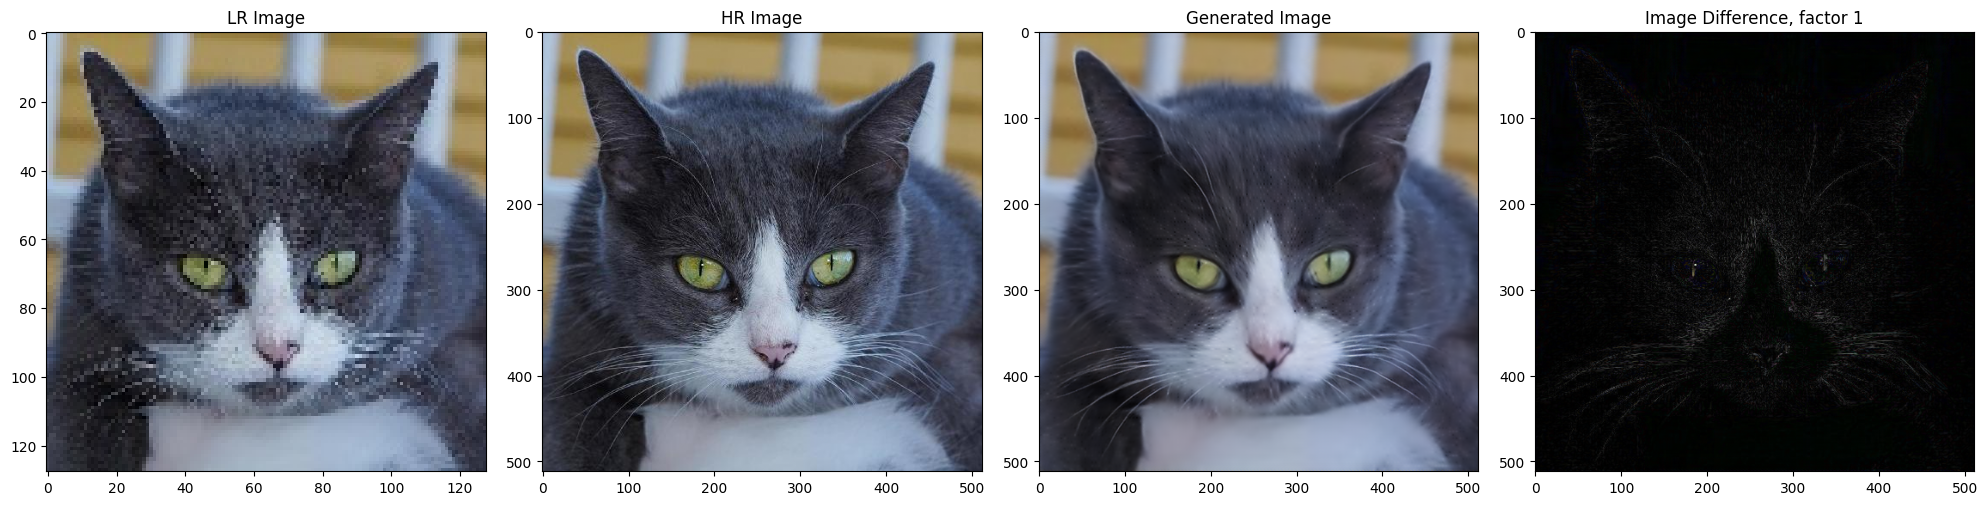

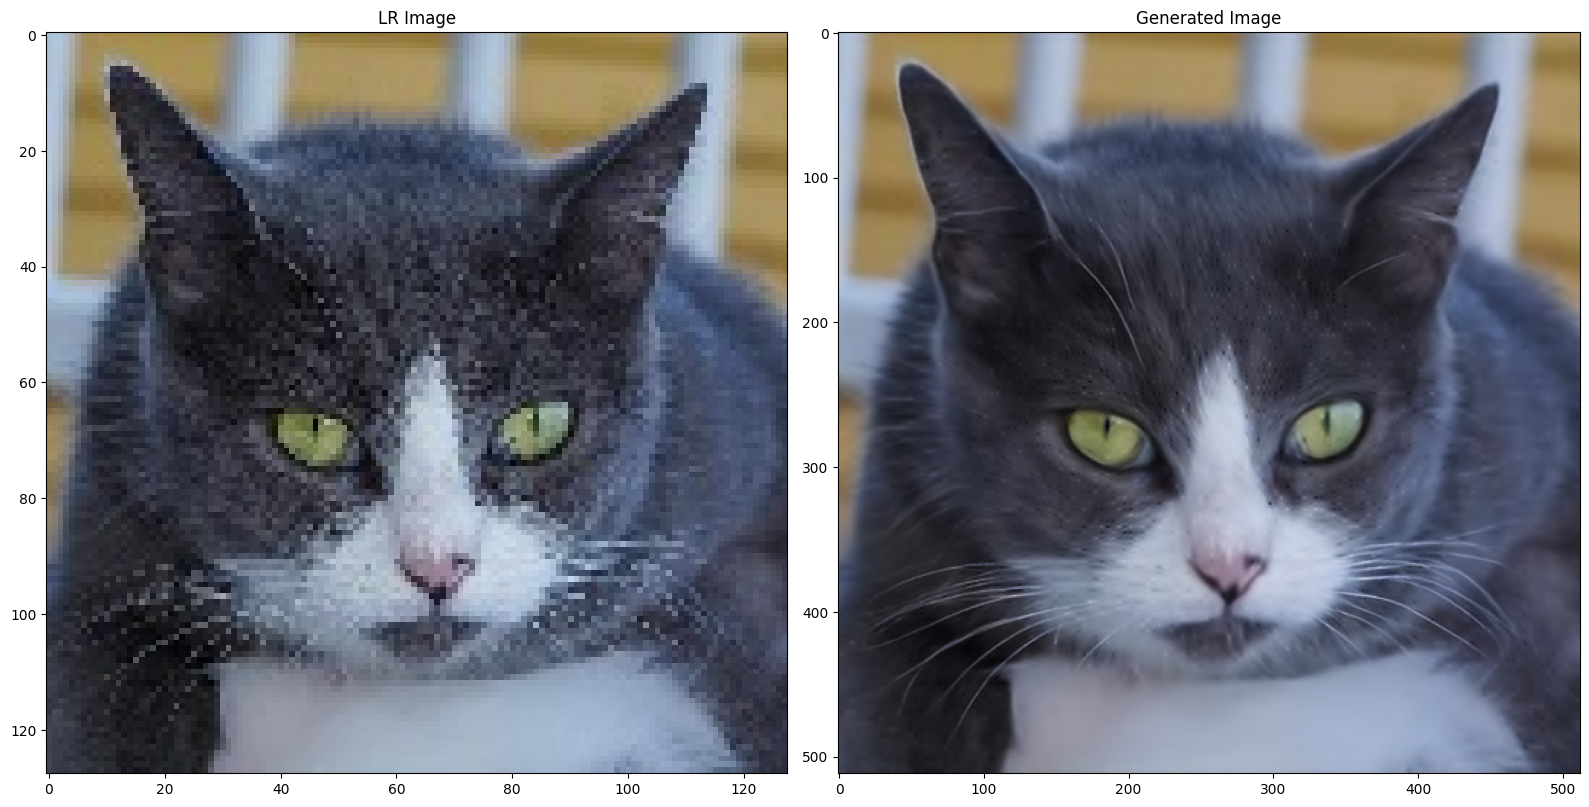

Cosine similarity:  0.9957263284225878
Cosine similarity (bicubic):  0.9940668316705296
Visual Information Fidelity:  0.4632593681721573
Spatial Distortion Index:  0.18037513721105394


In [9]:
#Inference and Analysis
pictures = {
    'tiger':("testing_dataset/downscaled_ci_flickr_wild_002021.jpg","testing_dataset/flickr_wild_002021.jpg"),
    'dog':("testing_dataset/downscaled_ci_pixabay_dog_001489.jpg","testing_dataset/pixabay_dog_001489.jpg"),
    'wolf':("testing_dataset/downscaled_ci_pixabay_wild_000639.jpg","testing_dataset/pixabay_wild_000639.jpg"),
    'cat1':('testing_dataset/downscaled_ci_flickr_cat_000004.jpg','testing_dataset/flickr_cat_000004.jpg'),
    'cat2':('testing_dataset/downscaled_ci_flickr_cat_000005.jpg','testing_dataset/flickr_cat_000005.jpg'),
    'mufasa':('testing_dataset/downscaled_ci_pixabay_wild_000568.jpg','testing_dataset/pixabay_wild_000568.jpg'),
    'scar':('testing_dataset/downscaled_ci_pixabay_wild_000561.jpg','testing_dataset/pixabay_wild_000561.jpg'),
    'pastyScar':('LR_images/ci/downscaled_ci_flickr_wild_001704.jpg','HR_images/flickr_wild_001704.jpg'),
    'monkeyLion':('testing_dataset/downscaled_ci_flickr_wild_001751.jpg','testing_dataset/flickr_wild_001751.jpg'),
    'leopard':('testing_dataset/downscaled_ci_flickr_wild_002181.jpg','testing_dataset/flickr_wild_002181.jpg'),
    'night_leopard':('testing_dataset/downscaled_ci_flickr_wild_002162.jpg','testing_dataset/flickr_wild_002162.jpg'),
    'white_tiger':('testing_dataset/downscaled_ci_flickr_wild_000895.jpg','testing_dataset/flickr_wild_000895.jpg'),
    'cub':('testing_dataset/downscaled_ci_flickr_wild_000812.jpg','testing_dataset/flickr_wild_000812.jpg'),#812-816
    'kyri':('extraPics/LR_kitties5.jpg'),
    'Mina':('extraPics/MinaSmall.jpg'),
    'wave':("extraPics/downscaled_ci_waves.jpg","extraPics/waves.jpg"),
    'noise':('extraPics/lr_noise.jpg','extraPics/hr_noise.jpg'),
}

lr, hr = pictures['cat2']

print("Model Metrics")
input,target,output,difference = compare(lr, hr, difference_factors=[1])
enhance(lr,display=True)
cos_similarity = HM.cosine_similarity(output, target)

bicubic_output =  HM.upscale_image_bicubic(lr,4)

print("Cosine similarity: ", cos_similarity)
print("Cosine similarity (bicubic): ", HM.cosine_similarity(np.array(bicubic_output), target))
print("Visual Information Fidelity: ", sw.vifp(target, output))
print("Spatial Correlation Coefficient: ", sw.scc(target, output))
# print("Bicubic Metrics")
# compute_metrics(target,bicubic_output)


# plt.imshow(np.array(bicubic_output))
# plt.title('Bicubic Upscaling')
# plt.show()

In [6]:
# Fourier Analysis

difference = abs(target-output)
# fourier_map(input,"Input Image",display=True)
# rt,gt,bt = fourier_map(target,"Target Image",display=False)
# ro,go,bo = fourier_map(output,"Generated Image",display=False)
# display_fourier_maps(difference,"Difference",rt-ro,gt-go,bt-bo)


In [7]:
## some conv attempts -- Sobel Kernel##
#image = transform.ToPILImage()(image)
'''
v_kernel is conv kernel to detect vertical edges, similar for h_kernel
sobel kernel is a specific kernel that also detects edges
'''
# v_kernel = np.array([[[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]],
#                      [[-2,-2,-2],[-1,-1,-1],[0,0,0],[1,1,1],[2,2,2]]])
# v_kernel = np.array([[[-1,-1,-1],[0,0,0],[1,1,1]],
#                      [[-2,-2,-2],[0,0,0],[2,2,2]],
#                      [[-1,-1,-1],[0,0,0],[1,1,1]]])
# h_kernel = np.transpose(v_kernel,(1,0,2))
kernel = np.array([[[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]],
                     [[-1,-1,-1],[8,8,8],[-1,-1,-1]],
                     [[-1,-1,-1],[-1,-1,-1],[-1,-1,-1]]])

target = difference_image
contrasted = convolve(target,kernel)
plt.imshow(contrasted)
plt.show()
# target_v_edges = convolve(target, v_kernel)
# target_h_edges = convolve(target,h_kernel)
# target_avg = (target_v_edges + target_h_edges)//2

# generated_v_edges = convolve(output_im, v_kernel)
# generated_h_edges = convolve(output_im,h_kernel)
# generated_avg = (generated_h_edges+generated_v_edges)//2
# Create a figure with subplots
# fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# # Display images in subplots
# axes[0][0].imshow(target)
# axes[0][0].set_title('Target Image')
# axes[1][0].imshow(output_im)
# axes[1][0].set_title('Generated Image')

# axes[0][1].imshow(target_v_edges)
# axes[0][1].set_title('Vertical Edges')
# axes[1][1].imshow(generated_v_edges)
# axes[1][1].set_title('Vertical Edges')

# axes[0][2].imshow(target_h_edges)
# axes[0][2].set_title('Horizontal Edges')
# axes[1][2].imshow(generated_h_edges)
# axes[1][2].set_title('Horizontal Edges')

# axes[0][3].imshow(target_avg)
# axes[0][3].set_title('Both Edges')
# axes[1][3].imshow(generated_avg)
# axes[1][3].set_title('Both Edges')

# # Adjust spacing between subplots
# plt.tight_layout()
# # Show the plot
# plt.show()

NameError: name 'difference_image' is not defined

In [ ]:
# Band Pass Fourier Filters 

def band_pass_channel(channel, mask,color):
    #transform to frequency domain with FFT
    f = np.fft.fft2(channel)
    f_shift = np.fft.fftshift(f)
    
    #mask specific frequencies
    f_shift_filtered = f_shift * mask
    
    #invert back to get new image
    f_inverse_shift = np.fft.ifftshift(f_shift_filtered)
    channel_filtered = np.fft.ifft2(f_inverse_shift)
    channel_filtered = np.abs(channel_filtered).astype(int)#remove imaginary part, and make sure integers
    return channel_filtered

def band_pass_filter(img,r1,r2):

    # Split the image into color channels
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    
    rows, cols, depth = img.shape
    center_row, center_col = rows // 2, cols // 2#get center
    
    # # Create a circular mask
    mask = np.zeros((rows, cols), np.uint8)#get rid of everything
    mask = cv2.circle(mask, (center_col, center_row), r2, 1, -1)#actually keep disk of r2
    if r1>0:
        mask = cv2.circle(mask, (center_col, center_row), r1, 0, -1)    #actually get rid of inner disk again r1 (creating band)
    # plt.imshow(mask,cmap='gray')
    # plt.show()
    # print(mask)
    
    #mask each color
    r_filtered = band_pass_channel(r, mask,'R')
    g_filtered = band_pass_channel(g, mask,'G')
    b_filtered = band_pass_channel(b, mask,'B')
    #combine to one image
    filtered_image = cv2.merge((r_filtered, g_filtered, b_filtered))
    return filtered_image,mask


img = output_image
plt.imshow(img)
plt.title("Generated Image")
plt.show()
fig, axes = plt.subplots(3,3,figsize=(12,12))
for i in range(3):
    # inner = (i*(i+19)**2)//400
    inner=10
    outer = inner+50*(i+1)
    filtered,mask = band_pass_filter(img,inner,outer)
    change = abs(filtered - img)
    axes[i][0].imshow(filtered)
    axes[i][0].set_title("Filtered: " + str(inner)+","+str(outer))
    axes[i][1].imshow(change)
    axes[i][1].set_title("Difference: ")
    axes[i][2].imshow(mask,cmap='gray')
    axes[i][2].set_title("Mask Used")
plt.tight_layout()
plt.show()

# filtered,mask = high_pass_filter(img,30,100)
# plt.imshow(filtered)
# plt.show()

In [ ]:
# Difference between target and generated image band pass filter

fig, axes = plt.subplots(1,2,figsize=(12,12))
axes[0].imshow(target_image)
axes[0].set_title("Target Image")
axes[1].imshow(output_image)
axes[1].set_title("Generated Image")
plt.show()

fig, axes = plt.subplots(2,4,figsize=(16,16))
for i in range(2):
    # inner = (i*(i+19)**2)//400
    # outer = inner+100*(i+1)
    inner= 0
    outer = 75*i+75
    target_filtered, target_mask = band_pass_filter(target_image,inner,outer)
    output_filtered, output_mask = band_pass_filter(output_image,inner,outer)
    change = abs(target_filtered - output_filtered)
    axes[i][0].imshow(target_filtered)
    axes[i][0].set_title("Filtered Target: " + str(inner)+","+str(outer))
    axes[i][1].imshow(output_filtered)
    axes[i][1].set_title("Filtered Output: ")
    axes[i][2].imshow(change)
    axes[i][2].set_title("difference:")
    axes[i][3].imshow(target_mask,cmap='gray')
    axes[i][3].set_title("Mask Used")
    print(np.min(target_filtered),np.max(target_filtered))
    # find MSE
    mse = np.mean((change)**2)
    print("MSE: ",mse)
    # use HiFilterLoss to find mse
    loss_fn = HiFilterLoss(inner,outer)
    loss = loss_fn(target_image, output_image)
    print("HiFilterLoss: ",loss)
plt.tight_layout()
plt.show()



# loss_fn2 = HiFilterLossTensor(20, 300)

# target_image_tensor = transform(target_image)
# output_image_tensor = transform(output_image)
# loss = loss_fn2(target_image, output_image)
# print("HiFilterLossTensor: ",loss)
